<a href="https://colab.research.google.com/github/ANANTHUPADHYA/team-combined-factors/blob/main/Context_Veracity_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Context Veracity

Datset and Notebook to Scrape data from Politifiact

Politifact scraped data is performed. The scraping is done in a **separate notebook**.



Fake news can take on many forms, including photoshopped images, fake user-generated content or spoofed accounts, network-based content designed to appeal to a particular organization or group, as well as knowledge-based stories that contain a scientific or reasonable explanation of unresolved issues, often resulting in the spread of false information.


The factor chosen for Fake news detection is Context veracity. The dataset used is scrapped data from Politifact. Along with scraping the news addtional source information for the news is also scrapped.
To determince context veracity we need to find evidence for the news topic.

##Data Narrative

Misinformation detection, which has become an increasingly important topic in Natural Language Processing. Misinformation refers to the distribution of false information in the context of news. 

For this Assignment the Liar Liar Plus dataset is used. The Liar Liar Plus dataset provides information about the source of a news and the score count for the source. For each source it determines the number of False / Ture counts.
This information was not included in the original Liar Liar dataset. Hence in the Liar Liar plus dataset further analysis of the source is included.

Along with this Politifact scrapped data is also used. For each news post Politifact proiveds source information which is  also scrapped to gather relaibility of the source.

##Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import csv
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from scipy import sparse

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


##Import the Liar Liar Plus dataset

In [ ]:
# Reading the tsv file into DataFrame
test_filename = '/content/sample_data/test.tsv'
train_filename = '/content/sample_data/train.tsv'
valid_filename =  '/content/sample_data/valid.tsv'

colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytruecounts','pantsonfirecounts','context']

train_news = pd.read_csv(train_filename, sep='\t', names = colnames, error_bad_lines=False)
test_news = pd.read_csv(test_filename, sep='\t', names = colnames, error_bad_lines=False)
valid_news = pd.read_csv(valid_filename, sep='\t', names = colnames, error_bad_lines=False)

In [ ]:
train_news.head()

,jsonid,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
# Dropping the 'id' column
train_news.drop('jsonid', axis = 1, inplace = True)
test_news.drop('jsonid', axis = 1, inplace = True)
valid_news.drop('jsonid', axis = 1, inplace = True)

In [ ]:
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
# Checking the shape of data
print(train_news.shape)
print(valid_news.shape)
print(test_news.shape)

(10240, 13)
(1284, 13)
(1267, 13)


#Data Cleaning and Text Preprocessing#

As a part of cleaning, we will perform below steps:
1. Remove Special characters
2. Convert text to lower case
3. Tokenization
4. Removing stop words
5. Lemmetization
6. Stemming

In [ ]:
import re

def cleaning(raw_text):
    import nltk
    
    # 1. Remove non-letters/Special Characters
    text = re.sub("[^a-zA-Z]", " ", str(raw_text))
    
    # 2. Convert to lower case.
    text =  text.lower()
    
    # 3. Tokenize.
    text_words = nltk.word_tokenize(text)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  text_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

In [ ]:
import time
import nltk
nltk.download('punkt')
nltk.download('wordnet')
# clean training and test data 
# create new column "tokenized"
t1 = time.time()

# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
train_news['clean_text'] = train_news["headline_text"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem train data: \n", len(train_news), "news:", (t2-t1)/60, "min")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

Time to clean, tokenize and stem train data: 
 10240 news: 0.12315709193547567 min


#Data Visualization#

In [ ]:
# Final data present in datset after data preprocessing, and cleaning
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,clean_text
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimes...
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,declin coal start start natur gas took start b...
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillari clinton agre john mccain vote give geo...
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legisl like mandat free sex...
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term


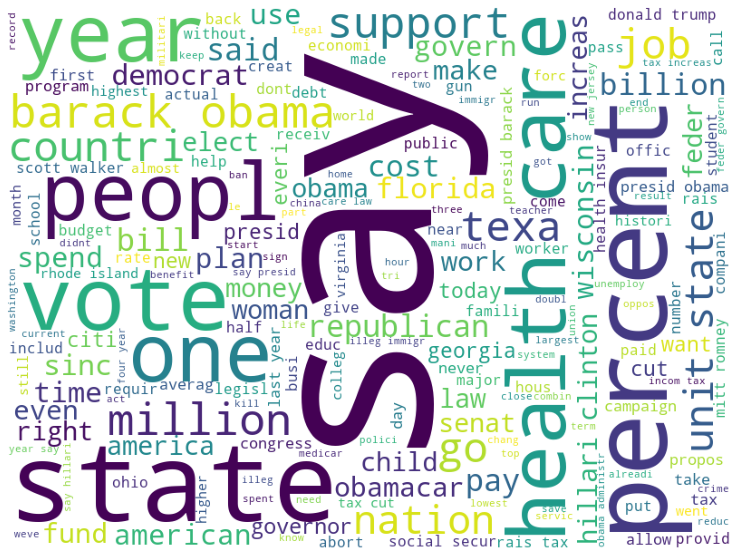

In [ ]:
#Word cloud of Train dataset

from wordcloud import WordCloud, STOPWORDS
def wcloud(data,backgroundcolor = 'white', width = 800, height = 600):
    word_cloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
wcloud(' '.join(train_news['clean_text']))


##Prepare Test and Validation dataset

###Test Data

In [ ]:
# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
test_news['clean_text'] = test_news["headline_text"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem test data: \n", len(test_news), "news:", (t2-t1)/60, "min")


Time to clean, tokenize and stem test data: 
 1267 news: 0.19006035327911378 min


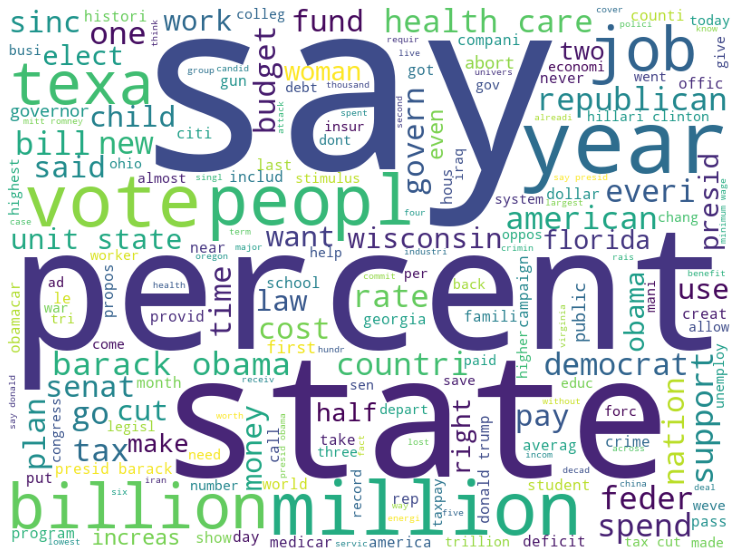

In [ ]:
#Word cloud of Test dataset

from wordcloud import WordCloud, STOPWORDS
def wcloud(data,backgroundcolor = 'white', width = 800, height = 600):
    word_cloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
wcloud(' '.join(test_news['clean_text']))

###Validation Dataset

In [ ]:
# Add the processed data to the original data. 
# Perhaps using apply function would be more elegant and concise than using for loop
valid_news['clean_text'] = valid_news["headline_text"].apply(cleaning) 

t2 = time.time()
print("\nTime to clean, tokenize and stem validation data: \n", len(test_news), "news:", (t2-t1)/60, "min")


Time to clean, tokenize and stem validation data: 
 1267 news: 0.23934342861175537 min


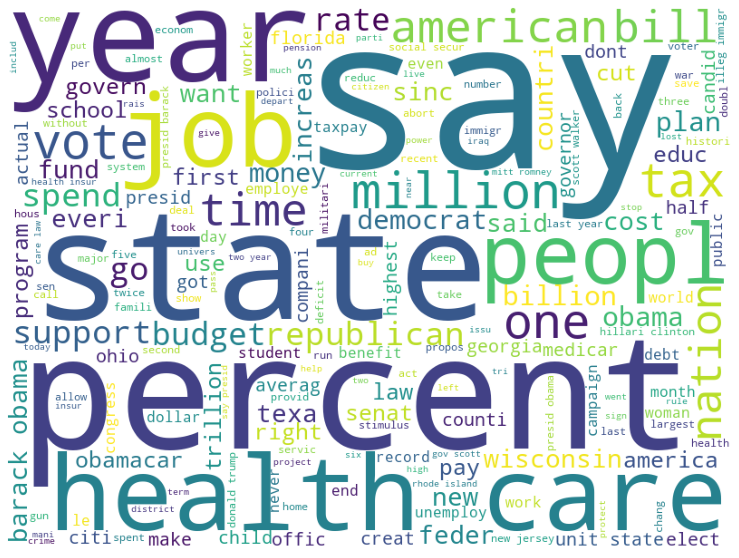

In [ ]:
#Word cloud of Validation dataset

from wordcloud import WordCloud, STOPWORDS
def wcloud(data,backgroundcolor = 'white', width = 800, height = 600):
    word_cloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
wcloud(' '.join(valid_news['clean_text']))

In [ ]:
#train_news = train_news.append(test_news).append(valid_news)

In [ ]:
train_news.shape

(10240, 14)

#Verify Veracity 

In [ ]:
#Find unique values for Label column
train_news.label.unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

In [ ]:
#Check the total records in the Train dataset
train_news.shape

(10240, 14)

In [ ]:
#As some of the Label values are 'NaN' lets drop records with 'NaN' as label value
train_news = train_news.dropna(subset=['label'])

There were 2 records with label as Nan which are dropped now

In [ ]:
train_news.shape

(10240, 14)

In [ ]:
train_news.label.unique()

array(['false', 'half-true', 'mostly-true', 'true', 'barely-true',
       'pants-fire'], dtype=object)

Above are the 6 unique label values 

In [ ]:
#Use Scikit learn to convert string value to categorical
#Referrence: https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
train_news['label_cat'] = labelencoder.fit_transform(train_news['label'])
train_news

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,clean_text,label_cat
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimes...,1
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,declin coal start start natur gas took start b...,2
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillari clinton agre john mccain vote give geo...,3
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legisl like mandat free sex...,1
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report""",larger number shark attack florida case voter ...,3
10236,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview,democrat becom parti atlanta metro area black,3
10237,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate,say altern social secur oper galveston counti ...,2
10238,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...,lift u cuban embargo allow travel cuba,1


In [ ]:
train_news.label_cat.unique()

array([1, 2, 3, 5, 0, 4])

In [ ]:
train_news['veracity'] = 0

In [ ]:
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,clean_text,label_cat,veracity
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimes...,1,0
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,declin coal start start natur gas took start b...,2,0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillari clinton agre john mccain vote give geo...,3,0
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legisl like mandat free sex...,1,0
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term,2,0


## Calculate the precision and accuracy and determine the veracity

In [ ]:
falseNegative = 0
falsePositive = 0

trueNegative = 0
truePositive = 0


for index, row in train_news.iterrows():
  if (train_news.loc[index, 'label'] == 'pants_fire') | (train_news.loc[index, 'label'] == 'barely_true') | (train_news.loc[index, 'label'] == 'false'):
    if (train_news.loc[index, 'barelytruecounts'] > 4) | (train_news.loc[index, 'falsecounts'] >= 2) | (train_news.loc[index, 'pantsonfirecounts'] >= 1):
      trueNegative += 1
      train_news.loc[index,'veracity'] = 1
    else:
      falseNegative += 1
      train_news.loc[index,'veracity'] = 0
  else:
    if (train_news.loc[index, 'halftruecounts'] >= 2) | (train_news.loc[index, 'mostlytruecounts'] >= 1):
      truePositive += 1
      train_news.loc[index,'veracity'] = 1
    else:
      falsePositive += 1
      train_news.loc[index,'veracity'] = 0
    

print("trueNegative=", trueNegative)
print("falseNegative=", falseNegative)
print("truePositive=", truePositive)
print("falsePositive=", falsePositive)


trueNegative= 1411
falseNegative= 584
truePositive= 6424
falsePositive= 1821


In [ ]:
train_news

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,clean_text,label_cat,veracity
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimes...,1,0
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,declin coal start start natur gas took start b...,2,1
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillari clinton agre john mccain vote give geo...,3,1
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legisl like mandat free sex...,1,1
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,econom turnaround start end term,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,mostly-true,There are a larger number of shark attacks in ...,"animals,elections",aclu-florida,NaN,Florida,none,0.0,1.0,1.0,1.0,0.0,"interview on ""The Colbert Report""",larger number shark attack florida case voter ...,3,1
10236,mostly-true,Democrats have now become the party of the [At...,elections,alan-powell,NaN,Georgia,republican,0.0,0.0,0.0,1.0,0.0,an interview,democrat becom parti atlanta metro area black,3,1
10237,half-true,Says an alternative to Social Security that op...,"retirement,social-security",herman-cain,NaN,Georgia,republican,4.0,11.0,5.0,3.0,3.0,a Republican presidential debate,say altern social secur oper galveston counti ...,2,1
10238,false,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy",jeff-greene,NaN,Florida,democrat,3.0,1.0,3.0,0.0,0.0,a televised debate on Miami's WPLG-10 against ...,lift u cuban embargo allow travel cuba,1,0


In [ ]:
train_news.shape

(10240, 16)

In [ ]:
#Drop any Null values with no source information
train_news = train_news.dropna(how='any',axis=0) 

In [ ]:
train_news.shape

(6724, 16)

###Training the model on Liar Liar Plus data set

In [ ]:
col_names = ['barelytruecounts', 'falsecounts', 'halftruecounts', 'mostlytruecounts', 'pantsonfirecounts', 'veracity']
X = train_news[col_names]
Y = train_news['label_cat']

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.002)

###Logisitc Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=100000)
logmodel.fit(X_train,Y_train)
predictions = logmodel.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.67      0.57         3
           2       0.00      0.00      0.00         3
           3       0.12      1.00      0.22         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3

    accuracy                           0.21        14
   macro avg       0.10      0.28      0.13        14
weighted avg       0.12      0.21      0.14        14



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Naive Bayes Classifier

Using Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model = GaussianNB()

In [ ]:
model.fit(X_train,Y_train)

GaussianNB()

In [ ]:
pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix: \n")
print(confusion_matrix(Y_test,pred))
print("Classification Report:\n")
print(classification_report(Y_test,pred))
print('Accuracy score for Naive Bayes:\n', accuracy_score(Y_test, pred))


Confusion Matrix: 

[[0 0 0 2 0 1]
 [0 0 0 1 2 0]
 [0 0 0 3 0 0]
 [0 0 0 1 0 0]
 [0 0 0 1 0 0]
 [0 0 0 2 0 1]]
Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       0.10      1.00      0.18         1
           4       0.00      0.00      0.00         1
           5       0.50      0.33      0.40         3

    accuracy                           0.14        14
   macro avg       0.10      0.22      0.10        14
weighted avg       0.11      0.14      0.10        14

Accuracy score for Naive Bayes:
 0.14285714285714285


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
train_news.head()

,label,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,context,clean_text,label_cat,veracity
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say anni list polit group support third trimes...,1,0
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,declin coal start start natur gas took start b...,2,1
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,hillari clinton agre john mccain vote give geo...,3,1
5,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,chicago bear start quarterback last year total...,5,1
7,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa.",person stage work activ last year pass along r...,2,1


In [ ]:
train_news.drop(['subject', 'speakerjobtitle', 'stateinfo', 'partyaffiliation', 'context'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_news.head()

,label,headline_text,speaker,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,clean_text,label_cat,veracity
0,false,Says the Annies List political group supports ...,dwayne-bohac,0.0,1.0,0.0,0.0,0.0,say anni list polit group support third trimes...,1,0
1,half-true,When did the decline of coal start? It started...,scott-surovell,0.0,0.0,1.0,1.0,0.0,declin coal start start natur gas took start b...,2,1
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,70.0,71.0,160.0,163.0,9.0,hillari clinton agre john mccain vote give geo...,3,1
5,true,The Chicago Bears have had more starting quart...,robin-vos,0.0,3.0,2.0,5.0,1.0,chicago bear start quarterback last year total...,5,1
7,half-true,I'm the only person on this stage who has work...,barack-obama,70.0,71.0,160.0,163.0,9.0,person stage work activ last year pass along r...,2,1


In [ ]:
#train_news.drop(['clean_text'], axis=1, inplace=True)

In [ ]:
train_news = train_news.rename(columns={'headline_text': 'Statement', 'speaker': 'Source', 'label': 'Label'})

In [ ]:
train_news.head()

,Label,Statement,Source,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,clean_text,label_cat,veracity
0,false,Says the Annies List political group supports ...,dwayne-bohac,0.0,1.0,0.0,0.0,0.0,say anni list polit group support third trimes...,1,0
1,half-true,When did the decline of coal start? It started...,scott-surovell,0.0,0.0,1.0,1.0,0.0,declin coal start start natur gas took start b...,2,1
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,70.0,71.0,160.0,163.0,9.0,hillari clinton agre john mccain vote give geo...,3,1
5,true,The Chicago Bears have had more starting quart...,robin-vos,0.0,3.0,2.0,5.0,1.0,chicago bear start quarterback last year total...,5,1
7,half-true,I'm the only person on this stage who has work...,barack-obama,70.0,71.0,160.0,163.0,9.0,person stage work activ last year pass along r...,2,1


Combine the counts of the author to determine the average source count

In [ ]:
 col_to_avg = ['barelytruecounts', 'falsecounts', 'pantsonfirecounts', 'halftruecounts', 'mostlytruecounts']
train_news['title_count'] = train_news[col_to_avg].mean(axis=1)


In [ ]:
train_news.head()

,Label,Statement,Source,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,clean_text,label_cat,veracity,title_count
0,false,Says the Annies List political group supports ...,dwayne-bohac,0.0,1.0,0.0,0.0,0.0,say anni list polit group support third trimes...,1,0,0.2
1,half-true,When did the decline of coal start? It started...,scott-surovell,0.0,0.0,1.0,1.0,0.0,declin coal start start natur gas took start b...,2,1,0.4
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,70.0,71.0,160.0,163.0,9.0,hillari clinton agre john mccain vote give geo...,3,1,94.6
5,true,The Chicago Bears have had more starting quart...,robin-vos,0.0,3.0,2.0,5.0,1.0,chicago bear start quarterback last year total...,5,1,2.2
7,half-true,I'm the only person on this stage who has work...,barack-obama,70.0,71.0,160.0,163.0,9.0,person stage work activ last year pass along r...,2,1,94.6


Round of the float value

In [ ]:
train_news['title_count'] = train_news['title_count'].astype(int)
#train_news['Label'] = train_news['Label'].astype(int)

In [ ]:
train_news.head()

,Label,Statement,Source,barelytruecounts,falsecounts,halftruecounts,mostlytruecounts,pantsonfirecounts,clean_text,label_cat,veracity,title_count
0,false,Says the Annies List political group supports ...,dwayne-bohac,0.0,1.0,0.0,0.0,0.0,say anni list polit group support third trimes...,1,0,0
1,half-true,When did the decline of coal start? It started...,scott-surovell,0.0,0.0,1.0,1.0,0.0,declin coal start start natur gas took start b...,2,1,0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,70.0,71.0,160.0,163.0,9.0,hillari clinton agre john mccain vote give geo...,3,1,94
5,true,The Chicago Bears have had more starting quart...,robin-vos,0.0,3.0,2.0,5.0,1.0,chicago bear start quarterback last year total...,5,1,2
7,half-true,I'm the only person on this stage who has work...,barack-obama,70.0,71.0,160.0,163.0,9.0,person stage work activ last year pass along r...,2,1,94


In [ ]:
col_to_drop = ['barelytruecounts', 'falsecounts', 'pantsonfirecounts', 'halftruecounts', 'mostlytruecounts']
train_news.drop(col_to_drop, axis=1, inplace=True)

In [ ]:
train_news.head()

,Label,Statement,Source,clean_text,label_cat,veracity,title_count
0,false,Says the Annies List political group supports ...,dwayne-bohac,say anni list polit group support third trimes...,1,0,0
1,half-true,When did the decline of coal start? It started...,scott-surovell,declin coal start start natur gas took start b...,2,1,0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,hillari clinton agre john mccain vote give geo...,3,1,94
5,true,The Chicago Bears have had more starting quart...,robin-vos,chicago bear start quarterback last year total...,5,1,2
7,half-true,I'm the only person on this stage who has work...,barack-obama,person stage work activ last year pass along r...,2,1,94


In [ ]:
#Break point
#import pdb; pdb.set_trace()

#Text Vectorizer and Embeddings

In [ ]:
df_main = train_news.copy(deep=True)

In [ ]:
df_main

,Label,Statement,Source,clean_text,label_cat,veracity,title_count
0,false,Says the Annies List political group supports ...,dwayne-bohac,say anni list polit group support third trimes...,1,0,0
1,half-true,When did the decline of coal start? It started...,scott-surovell,declin coal start start natur gas took start b...,2,1,0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,hillari clinton agre john mccain vote give geo...,3,1,94
5,true,The Chicago Bears have had more starting quart...,robin-vos,chicago bear start quarterback last year total...,5,1,2
7,half-true,I'm the only person on this stage who has work...,barack-obama,person stage work activ last year pass along r...,2,1,94
...,...,...,...,...,...,...,...
10227,pants-fire,"Recently though, the media has reported on tho...",john-rafferty,recent though medium report thousand illeg vot...,4,0,0
10228,barely-true,Stopped by Smiley Cookie to pick up some great...,donald-trump,stop smiley cooki pick great cooki famili alon...,0,1,65
10230,barely-true,The Supreme Courts views are radically out of ...,ted-cruz,suprem court view radic step public opinion re...,0,1,22
10231,half-true,"When it comes to the state deficit, Wisconsin ...",alberta-darling,come state deficit wisconsin proport much trou...,2,1,1


##Common Words

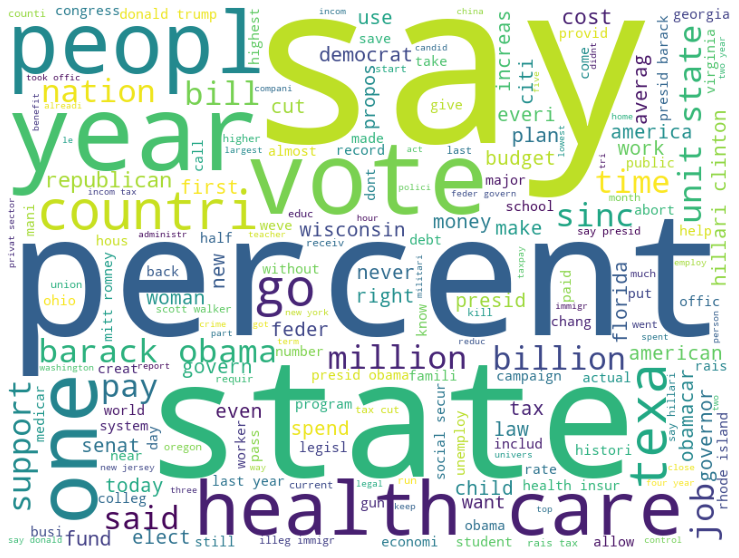

In [ ]:
common_words = wcloud(' '.join(df_main['clean_text']))

In [ ]:
 cleanText = df_main['clean_text']

In [ ]:
from nltk.tokenize import word_tokenize

cleanText = cleanText.apply(word_tokenize)
cleanText.head()

0    [say, anni, list, polit, group, support, third...
1    [declin, coal, start, start, natur, gas, took,...
2    [hillari, clinton, agre, john, mccain, vote, g...
5    [chicago, bear, start, quarterback, last, year...
7    [person, stage, work, activ, last, year, pass,...
Name: clean_text, dtype: object

In [ ]:
cleanText_list = cleanText.to_list()

In [ ]:
cleanText_list

[['say',
  'anni',
  'list',
  'polit',
  'group',
  'support',
  'third',
  'trimest',
  'abort',
  'demand'],
 ['declin',
  'coal',
  'start',
  'start',
  'natur',
  'gas',
  'took',
  'start',
  'begin',
  'presid',
  'georg',
  'w',
  'bush',
  'administr'],
 ['hillari',
  'clinton',
  'agre',
  'john',
  'mccain',
  'vote',
  'give',
  'georg',
  'bush',
  'benefit',
  'doubt',
  'iran'],
 ['chicago',
  'bear',
  'start',
  'quarterback',
  'last',
  'year',
  'total',
  'number',
  'tenur',
  'uw',
  'faculti',
  'fire',
  'last',
  'two',
  'decad'],
 ['person',
  'stage',
  'work',
  'activ',
  'last',
  'year',
  'pass',
  'along',
  'rus',
  'feingold',
  'toughest',
  'ethic',
  'reform',
  'sinc',
  'waterg'],
 ['say',
  'gop',
  'primari',
  'oppon',
  'glenn',
  'grothman',
  'joe',
  'leibham',
  'cast',
  'compromis',
  'vote',
  'cost',
  'million',
  'higher',
  'electr',
  'cost'],
 ['first',
  'time',
  'histori',
  'share',
  'nation',
  'popular',
  'vote',
  'ma

In [ ]:
user_ids = df_main.index.unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user2user_encoded

{0: 0,
 1: 1,
 2: 2,
 5: 3,
 7: 4,
 9: 5,
 10: 6,
 11: 7,
 12: 8,
 14: 9,
 15: 10,
 16: 11,
 18: 12,
 19: 13,
 20: 14,
 22: 15,
 24: 16,
 25: 17,
 26: 18,
 27: 19,
 28: 20,
 29: 21,
 30: 22,
 31: 23,
 32: 24,
 33: 25,
 34: 26,
 35: 27,
 36: 28,
 39: 29,
 40: 30,
 44: 31,
 45: 32,
 47: 33,
 50: 34,
 52: 35,
 53: 36,
 54: 37,
 55: 38,
 56: 39,
 57: 40,
 58: 41,
 61: 42,
 62: 43,
 64: 44,
 65: 45,
 66: 46,
 67: 47,
 69: 48,
 70: 49,
 71: 50,
 72: 51,
 74: 52,
 75: 53,
 76: 54,
 79: 55,
 80: 56,
 81: 57,
 85: 58,
 86: 59,
 87: 60,
 88: 61,
 89: 62,
 90: 63,
 91: 64,
 93: 65,
 94: 66,
 96: 67,
 97: 68,
 98: 69,
 102: 70,
 103: 71,
 104: 72,
 105: 73,
 106: 74,
 107: 75,
 108: 76,
 109: 77,
 110: 78,
 112: 79,
 113: 80,
 114: 81,
 116: 82,
 118: 83,
 119: 84,
 120: 85,
 121: 86,
 122: 87,
 124: 88,
 126: 89,
 131: 90,
 132: 91,
 133: 92,
 136: 93,
 139: 94,
 141: 95,
 142: 96,
 143: 97,
 144: 98,
 145: 99,
 146: 100,
 147: 101,
 148: 102,
 149: 103,
 150: 104,
 153: 105,
 154: 106,
 155: 107

In [ ]:
df_main["encodedIndex"] = df_main.index.map(user2user_encoded)

In [ ]:
df_main.head()

,Label,Statement,Source,clean_text,label_cat,veracity,title_count,encodedIndex
0,false,Says the Annies List political group supports ...,dwayne-bohac,say anni list polit group support third trimes...,1,0,0,0
1,half-true,When did the decline of coal start? It started...,scott-surovell,declin coal start start natur gas took start b...,2,1,0,1
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,hillari clinton agre john mccain vote give geo...,3,1,94,2
5,true,The Chicago Bears have had more starting quart...,robin-vos,chicago bear start quarterback last year total...,5,1,2,3
7,half-true,I'm the only person on this stage who has work...,barack-obama,person stage work activ last year pass along r...,2,1,94,4


In [ ]:
df_main.shape

(6724, 8)

In [ ]:
def tokenize(sentences):
    words = []
    for sentence in sentences:
        w = word_extraction(sentence)
        words.extend(w)
        
    words = sorted(list(set(words)))
    return words

def word_extraction(sentence):
    ignore = ['a', "the", "is"]
    words = re.sub("[^\w]", " ",  str(sentence)).split()
    cleaned_text = [w.lower() for w in words if w not in ignore]
    return cleaned_text    
    
def generate_bow(allsentences):    
    vocab = tokenize(allsentences)
    #print("Word List for Document \n{0} \n".format(vocab));
    

    for sentence in allsentences:
        words = word_extraction(sentence)
        bag_vector = np.zeros(len(vocab))
        for w in words:
            for i,word in enumerate(vocab):
                if word == w: 
                    bag_vector[i] += 1
                    
                #print("{0}\n".format(np.array(bag_vector)))
        return np.array(bag_vector)


allsentences = df_main["Statement"].to_list()


bag_vector = generate_bow(allsentences)

In [ ]:
bag_vector

array([0., 0., 0., ..., 0., 0., 0.])

##Prepare text for LDA Analysis

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


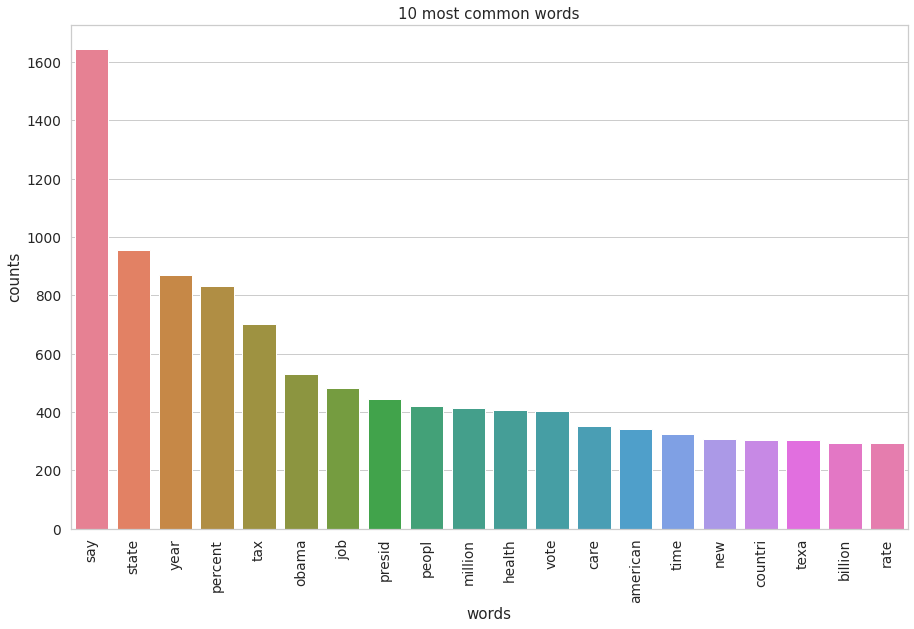

In [ ]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_main['clean_text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)


In [ ]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 10
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
say plan romney mitt vote obama presid american said citi

Topic #1:
school say state rate percent secur social highest world public

Topic #2:
health care say insur republican democrat obama campaign senat million

Topic #3:
state say govern percent feder increas counti island year court

Topic #4:
state percent american say florida countri feder rick gov tax

Topic #5:
percent peopl border say immigr work million vote obama illeg

Topic #6:
year obama presid state percent job say tax sinc billion

Topic #7:
tax job say percent year rais pay busi million new

Topic #8:
say vote said state mccain trump senat donald john sen

Topic #9:
say state texa law school legisl citi new feder gun


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##Counter Vectorize

In [ ]:
df_main.index = range(6724)
df_main['Statement'].apply(lambda x: len(str(x).split(' '))).sum()

121150

In [ ]:
title = df_main['clean_text'].to_list()

In [ ]:
title

['say anni list polit group support third trimest abort demand',
 'declin coal start start natur gas took start begin presid georg w bush administr',
 'hillari clinton agre john mccain vote give georg bush benefit doubt iran',
 'chicago bear start quarterback last year total number tenur uw faculti fire last two decad',
 'person stage work activ last year pass along rus feingold toughest ethic reform sinc waterg',
 'say gop primari oppon glenn grothman joe leibham cast compromis vote cost million higher electr cost',
 'first time histori share nation popular vote margin smaller latino vote margin',
 'sinc near million american slip middl class poverti',
 'mitt romney governor massachusett didnt slow rate growth govern actual cut',
 'afford care act alreadi sens waiv otherwis suspend',
 'last elect novemb percent american peopl chose vote percent young peopl percent low incom worker chose vote',
 'mccain oppos requir govern buy american made motorcycl said buy american provis quot disgr

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
count_vector=cvec.fit_transform(title)

In [ ]:
count_vector

<6724x6100 sparse matrix of type '<class 'numpy.int64'>'
	with 66809 stored elements in Compressed Sparse Row format>

In [ ]:
print(count_vector)

  (0, 4682)	1
  (0, 223)	1
  (0, 3106)	1
  (0, 4066)	1
  (0, 2295)	1
  (0, 5266)	1
  (0, 5449)	1
  (0, 5591)	1
  (0, 14)	1
  (0, 1364)	1
  (1, 1321)	1
  (1, 982)	1
  (1, 5109)	3
  (1, 3537)	1
  (1, 2148)	1
  (1, 5513)	1
  (1, 470)	1
  (1, 4155)	1
  (1, 2175)	1
  (1, 707)	1
  (1, 74)	1
  (2, 2175)	1
  (2, 707)	1
  (2, 2446)	1
  (2, 965)	1
  :	:
  (6721, 5139)	1
  (6721, 4415)	1
  (6721, 4298)	1
  (6722, 5115)	2
  (6722, 1344)	1
  (6722, 1007)	1
  (6722, 3490)	1
  (6722, 6000)	1
  (6722, 4215)	1
  (6722, 5601)	1
  (6722, 733)	1
  (6723, 2927)	1
  (6723, 1024)	1
  (6723, 3090)	1
  (6723, 5781)	1
  (6723, 5803)	2
  (6723, 1378)	1
  (6723, 92)	1
  (6723, 1018)	1
  (6723, 5242)	1
  (6723, 4360)	1
  (6723, 5386)	1
  (6723, 1714)	1
  (6723, 5204)	1
  (6723, 3219)	1


Now, let’s look at the vocabulary (collection of unique words)

In [ ]:
# show resulting vocabulary; the numbers are not counts, they are the position in the sparse vector.
cvec.vocabulary_

{'say': 4682,
 'anni': 223,
 'list': 3106,
 'polit': 4066,
 'group': 2295,
 'support': 5266,
 'third': 5449,
 'trimest': 5591,
 'abort': 14,
 'demand': 1364,
 'declin': 1321,
 'coal': 982,
 'start': 5109,
 'natur': 3537,
 'gas': 2148,
 'took': 5513,
 'begin': 470,
 'presid': 4155,
 'georg': 2175,
 'bush': 707,
 'administr': 74,
 'hillari': 2446,
 'clinton': 965,
 'agre': 118,
 'john': 2809,
 'mccain': 3280,
 'vote': 5845,
 'give': 2194,
 'benefit': 491,
 'doubt': 1552,
 'iran': 2734,
 'chicago': 890,
 'bear': 455,
 'quarterback': 4274,
 'last': 2986,
 'year': 6062,
 'total': 5525,
 'number': 3650,
 'tenur': 5399,
 'uw': 5770,
 'faculti': 1878,
 'fire': 1983,
 'two': 5632,
 'decad': 1313,
 'person': 3970,
 'stage': 5092,
 'work': 6026,
 'activ': 56,
 'pass': 3887,
 'along': 175,
 'rus': 4623,
 'feingold': 1935,
 'toughest': 5530,
 'ethic': 1786,
 'reform': 4411,
 'sinc': 4902,
 'waterg': 5898,
 'gop': 2231,
 'primari': 4167,
 'oppon': 3734,
 'glenn': 2204,
 'grothman': 2290,
 'joe': 280

In [ ]:
count_vector.shape

(6724, 6100)

As can be seen here after pre -processing the text and removing the stop words still the sparse matrix result is large

So further using MIN_DF to eliminate the less frequrntly used words.

###Stop Words using MIN_DF

The goal of MIN_DF is to ignore words that have very few occurrences to be considered meaningful. For example, in your text you may have names of people that may appear in only 1 or two documents. In some applications, this may qualify as noise and could be eliminated from further analysis.

The MIN_DF value can be an absolute value (e.g. 1, 2, 3, 4) or a value representing proportion of documents (e.g. 0.25 meaning, ignore words that have appeared in 25% of the documents) .

In [ ]:
# ignore terms that appeared in less than 2 documents 
cvec = CountVectorizer()
count_vector=cvec.fit_transform(title)

In [ ]:
count_vector.shape

(6724, 6100)

In [ ]:
cvec.vocabulary_

{'say': 4682,
 'anni': 223,
 'list': 3106,
 'polit': 4066,
 'group': 2295,
 'support': 5266,
 'third': 5449,
 'trimest': 5591,
 'abort': 14,
 'demand': 1364,
 'declin': 1321,
 'coal': 982,
 'start': 5109,
 'natur': 3537,
 'gas': 2148,
 'took': 5513,
 'begin': 470,
 'presid': 4155,
 'georg': 2175,
 'bush': 707,
 'administr': 74,
 'hillari': 2446,
 'clinton': 965,
 'agre': 118,
 'john': 2809,
 'mccain': 3280,
 'vote': 5845,
 'give': 2194,
 'benefit': 491,
 'doubt': 1552,
 'iran': 2734,
 'chicago': 890,
 'bear': 455,
 'quarterback': 4274,
 'last': 2986,
 'year': 6062,
 'total': 5525,
 'number': 3650,
 'tenur': 5399,
 'uw': 5770,
 'faculti': 1878,
 'fire': 1983,
 'two': 5632,
 'decad': 1313,
 'person': 3970,
 'stage': 5092,
 'work': 6026,
 'activ': 56,
 'pass': 3887,
 'along': 175,
 'rus': 4623,
 'feingold': 1935,
 'toughest': 5530,
 'ethic': 1786,
 'reform': 4411,
 'sinc': 4902,
 'waterg': 5898,
 'gop': 2231,
 'primari': 4167,
 'oppon': 3734,
 'glenn': 2204,
 'grothman': 2290,
 'joe': 280

In [ ]:
cvec.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaa',
 'aarp',
 'aba',
 'abandon',
 'abbott',
 'abc',
 'abdul',
 'abedin',
 'abel',
 'abid',
 'abil',
 'abl',
 'abolish',
 'abolit',
 'abort',
 'abortioneven',
 'abortionist',
 'abraham',
 'abramoff',
 'abroad',
 'abrupt',
 'absenc',
 'absent',
 'absente',
 'absolut',
 'absorb',
 'absurd',
 'abu',
 'abus',
 'academ',
 'academi',
 'acceler',
 'accept',
 'access',
 'accid',
 'accommod',
 'accomplish',
 'accord',
 'account',
 'accru',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'acela',
 'achiev',
 'acid',
 'acknowledg',
 'aclu',
 'acorn',
 'acquir',
 'acquisit',
 'acr',
 'across',
 'act',
 'action',
 'activ',
 'activist',
 'actor',
 'actual',
 'actuari',
 'acupunctur',
 'acut',
 'ad',
 'adam',
 'add',
 'addict',
 'addit',
 'address',
 'adegbil',
 'adequ',
 'adjust',
 'adler',
 'administ',
 'administr',
 'admir',
 'admiss',
 'admit',
 'adolf',
 'adopt',
 'adult',
 'adulteryand',
 'advanc',
 'advantag',
 'advertis',
 'advic',
 'advis',
 'advisor',
 'advisori',
 'advoc',
 'advocaci',
 '

In [ ]:
import pandas as pd

counts = pd.DataFrame(count_vector.toarray(),
                      columns=cvec.get_feature_names())
counts

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaa,aarp,aba,abandon,abbott,abc,abdul,abedin,abel,abid,abil,abl,abolish,abolit,abort,abortioneven,abortionist,abraham,abramoff,abroad,abrupt,absenc,absent,absente,absolut,absorb,absurd,abu,abus,academ,academi,acceler,accept,access,accid,accommod,accomplish,accord,account,accru,...,yarbrough,yard,year,yell,yemen,yes,yesterday,yesteryear,yet,yohoattempt,york,yorker,yost,youd,youll,young,younger,youngstown,your,youth,youthpass,youtub,youv,yr,yucca,yulin,yuppi,zack,zandi,zanesvill,zappala,zeldin,zero,zika,zip,zippo,zombi,zone,zoo,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6719,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6720,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6721,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6722,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#df = df_main.join(counts)
df = df_main

In [ ]:
df.head()

,Label,Statement,Source,clean_text,label_cat,veracity,title_count,encodedIndex
0,false,Says the Annies List political group supports ...,dwayne-bohac,say anni list polit group support third trimes...,1,0,0,0
1,half-true,When did the decline of coal start? It started...,scott-surovell,declin coal start start natur gas took start b...,2,1,0,1
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,hillari clinton agre john mccain vote give geo...,3,1,94,2
3,true,The Chicago Bears have had more starting quart...,robin-vos,chicago bear start quarterback last year total...,5,1,2,3
4,half-true,I'm the only person on this stage who has work...,barack-obama,person stage work activ last year pass along r...,2,1,94,4


##Gensim Word2Vec

The idea behind Word2Vec is pretty simple. We’re making an assumption that the meaning of a word can be inferred by the company it keeps. This is analogous to the saying, “show me your friends, and I’ll tell who you are”.

If you have two words that have very similar neighbors (meaning: the context in which it’s used is about the same), then these words are probably quite similar in meaning or are at least related. For example, the words shocked, appalled and astonished are usually used in a similar context.

In [ ]:
# imports needed and logging
import gzip
import gensim 
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Convert the dataframe column to list

In [ ]:
dataList = [] #empty list
for row in df_main.itertuples(): 
    mylist = [row.clean_text]
    dataList.append(mylist)

In [ ]:
dataList

[['say anni list polit group support third trimest abort demand'],
 ['declin coal start start natur gas took start begin presid georg w bush administr'],
 ['hillari clinton agre john mccain vote give georg bush benefit doubt iran'],
 ['chicago bear start quarterback last year total number tenur uw faculti fire last two decad'],
 ['person stage work activ last year pass along rus feingold toughest ethic reform sinc waterg'],
 ['say gop primari oppon glenn grothman joe leibham cast compromis vote cost million higher electr cost'],
 ['first time histori share nation popular vote margin smaller latino vote margin'],
 ['sinc near million american slip middl class poverti'],
 ['mitt romney governor massachusett didnt slow rate growth govern actual cut'],
 ['afford care act alreadi sens waiv otherwis suspend'],
 ['last elect novemb percent american peopl chose vote percent young peopl percent low incom worker chose vote'],
 ['mccain oppos requir govern buy american made motorcycl said buy ame

In [ ]:
# build vocabulary and train model
model = gensim.models.Word2Vec(
    dataList,
    size=150,
    window=10,
    min_count=2,
    workers=10,
    iter=10)

2021-12-05 00:41:57,799 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2021-12-05 00:41:57,801 : INFO : collecting all words and their counts
2021-12-05 00:41:57,803 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-12-05 00:41:57,820 : INFO : collected 6709 word types from a corpus of 6724 raw words and 6724 sentences
2021-12-05 00:41:57,822 : INFO : Loading a fresh vocabulary
2021-12-05 00:41:57,832 : INFO : effective_min_count=2 retains 14 unique words (0% of original 6709, drops 6695)
2021-12-05 00:41:57,835 : INFO : effective_min_count=2 leaves 29 word corpus (0% of original 6724, drops 6695)
2021-12-05 00:41:57,837 : INFO : deleting the raw counts dictionary of 6709 items
2021-12-05 00:41:57,839 : INFO : sample=0.001 downsamples 14 most-common words
2021-12-05 00:41:57,841 : INFO : downsampling leaves estimated 3 word corpus (13.2% of prior 29)
2021-12-05 00:41:57,844 : INFO : estimated required memory for 14 words

The step above, builds the vocabulary, and starts training the Word2Vec model. We will get to what these parameters actually mean later in this article. Behind the scenes, what’s happening here is that we are training a neural network with a single hidden layer where we train the model to predict the current word based on the context (using the default neural architecture). However, we are not going to use the neural network after training! Instead, the goal is to learn the weights of the hidden layer. These weights are essentially the word vectors that we’re trying to learn. The resulting learned vector is also known as the embeddings. You can think of these embeddings as some features that describe the target word. For example, the word `king` may be described by the gender, age, the type of people the king associates with, etc.w1

In [ ]:
def get_word2vec(sentences, location):
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    #print('Model done training. Saving to disk as ' + 'models/' + location)
    #model.save('models/' + location)
    return model

In [ ]:
all_titles = train_news['Statement'].append(test_news['headline_text']).append(valid_news['headline_text'])
w2vec = get_word2vec(
    all_titles,
    'w2vmodel'
)

2021-12-05 00:41:58,408 : INFO : collecting all words and their counts
2021-12-05 00:41:58,410 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2021-12-05 00:41:58,411 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-12-05 00:41:58,566 : INFO : collected 92 word types from a corpus of 991492 raw words and 9275 sentences
2021-12-05 00:41:58,568 : INFO : Loading a fresh vocabulary
2021-12-05 00:41:58,570 : INFO : effective_min_count=5 retains 84 unique words (91% of original 92, drops 8)
2021-12-05 00:41:58,572 : INFO : effective_min_count=5 leaves 991480 word corpus (99% of original 991492, drops 12)
2021-12-05 00:41:58,574 : INFO : deleting the raw counts dictionary of 92 items
2021-12-05 00:41:58,575 : INFO : sample=0.001 downsamples 28 most-common words
2021-12-05 00:41:58,577 : INFO : downsampling leaves estimated 219905 word corpus (22.2% of prior 991480)
2021-12-05 

##Comparing Accuracy

Here we calculate the accuracy after combining both dataset.

To determine the authenticity of a source not only the source information but the entire text of the source with other reliable resources need to be considered.

Hence the dataset from Politifact and the Liar Liar dataset are merged together and further checking the accuracy of the two datasets combined.

In [ ]:
df.head()

,Label,Statement,Source,clean_text,label_cat,veracity,title_count,encodedIndex
0,false,Says the Annies List political group supports ...,dwayne-bohac,say anni list polit group support third trimes...,1,0,0,0
1,half-true,When did the decline of coal start? It started...,scott-surovell,declin coal start start natur gas took start b...,2,1,0,1
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,hillari clinton agre john mccain vote give geo...,3,1,94,2
3,true,The Chicago Bears have had more starting quart...,robin-vos,chicago bear start quarterback last year total...,5,1,2,3
4,half-true,I'm the only person on this stage who has work...,barack-obama,person stage work activ last year pass along r...,2,1,94,4


In [ ]:
col_names1 = ['Statement', 'Label', 'Source', 'clean_text', 'label_cat']
X1 = df.drop(col_names1, axis=1)
Y1 = df['label_cat']

In [ ]:
X1
X1.dropna

<bound method DataFrame.dropna of       veracity  title_count  encodedIndex
0            0            0             0
1            1            0             1
2            1           94             2
3            1            2             3
4            1           94             4
...        ...          ...           ...
6719         0            0          6719
6720         1           65          6720
6721         1           22          6721
6722         1            1          6722
6723         0            0          6723

[6724 rows x 3 columns]>

In [ ]:

X1_train, X1_test, Y1_train, Y1_test = \
    train_test_split(X1, Y1, test_size=.2)

In [ ]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=100000)
logmodel.fit(X1_train,Y1_train)
predictions = logmodel.predict(X1_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y1_test,predictions))

              precision    recall  f1-score   support

           0       0.18      0.08      0.11       202
           1       0.22      0.15      0.18       236
           2       0.22      0.29      0.25       276
           3       0.27      0.68      0.39       287
           4       0.00      0.00      0.00        98
           5       0.00      0.00      0.00       246

    accuracy                           0.24      1345
   macro avg       0.15      0.20      0.16      1345
weighted avg       0.17      0.24      0.18      1345



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Naive Bayes

Using Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model = GaussianNB()

In [ ]:
X1_train = X1_train.dropna()
Y1_train = Y1_train.dropna()

In [ ]:
model.fit(X1_train,Y1_train)

GaussianNB()

In [ ]:
pred = model.predict(X1_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Confusion Matrix: \n")
print(confusion_matrix(Y1_test,pred))
print("Classification Report:\n")
print(classification_report(Y1_test,pred))
print('Accuracy score for Naive Bayes:\n', accuracy_score(Y1_test, pred))


Confusion Matrix: 

[[ 15  36   0 151   0   0]
 [ 21  40   0 175   0   0]
 [ 20  36   0 220   0   0]
 [  0   0   0 287   0   0]
 [  9  16   0  73   0   0]
 [ 20  50   0 176   0   0]]
Classification Report:

              precision    recall  f1-score   support

           0       0.18      0.07      0.10       202
           1       0.22      0.17      0.19       236
           2       0.00      0.00      0.00       276
           3       0.27      1.00      0.42       287
           4       0.00      0.00      0.00        98
           5       0.00      0.00      0.00       246

    accuracy                           0.25      1345
   macro avg       0.11      0.21      0.12      1345
weighted avg       0.12      0.25      0.14      1345

Accuracy score for Naive Bayes:
 0.25427509293680295


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Random Classifier

In [ ]:
# Create Random Forest classifer object
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train Random Forest Classifer
clf = clf.fit(X1_train,Y1_train)

#Predict the response for test dataset
Y1_pred = clf.predict(X1_test)

In [ ]:
X1_train.encodedIndex.min()

2

In [ ]:
# Accuracy
print("Accuracy:",metrics.accuracy_score(Y1_test, Y1_pred))

Accuracy: 0.2104089219330855


### Gini score

In [ ]:
import pandas as pd
col_names = ['Statement', 'Label', 'Source', 'clean_text', 'label_cat']
pima = df.drop(col_names, axis=1)
feature_imp = pd.Series(clf.feature_importances_,pima.columns).sort_values(ascending=False)
feature_imp

encodedIndex    0.884052
title_count     0.097611
veracity        0.018337
dtype: float64

2021-12-05 00:42:03,597 : WARNING : No handles with labels found to put in legend.


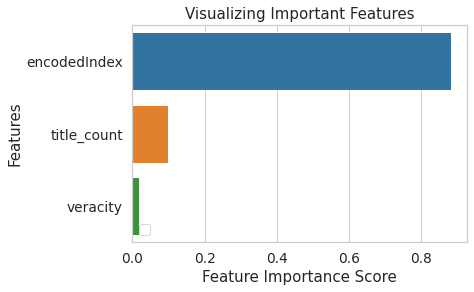

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

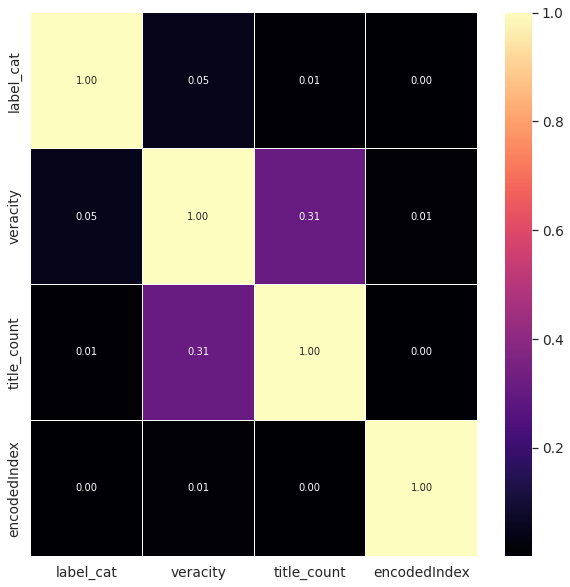

In [ ]:
fig,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_main.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
plt.show()

# Machine Learning Algorithm


In [ ]:
#Import Libraries
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
col_names2 = ['Statement', 'Label', 'Source', 'clean_text', 'label_cat']
X_data_reshape = df.drop(col_names2, axis=1)# Features
y_data = df.label_cat # Target variable

Split the data into Training set and Test data

### Different Classifiers

In [ ]:
from time import time
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


Create Train and Test data

In [ ]:
X, y = X_data_reshape, y_data

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)


In [ ]:
X_data_reshape

,veracity,title_count,encodedIndex
0,0,0,0
1,1,0,1
2,1,94,2
3,1,2,3
4,1,94,4
...,...,...,...
6719,0,0,6719
6720,1,65,6720
6721,1,22,6721
6722,1,1,6722


### Muller Loop

Apply different classifiers to get the test scores and accuracy

# Accuracy Comparison

In [ ]:
# TODO (Apply): All cross-validation

max_score = 0.0
max_class = ''
# iterate over classifiers
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
print(color.BOLD + color.BLUE + '########### Classifier Comparison ############\n\n' + color.END)
for name, clf in zip(names, classifiers):
    start_time = time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print(color.BOLD + color.PURPLE + 'Classifier = %s, Accuracy Score = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time) + color.END)
    print('\n')
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(color.BOLD + color.BLUE + '\n\n##############################################################' + color.END)
print('\n\n')
print(color.BOLD + color.BLUE + 80*'-' + color.END)
print('\n\n')
print(color.BOLD + color.GREEN + 'Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score) + color.END)
print('\n\n')
#plot the output of the various algorithms

########### Classifier Comparison ############


Classifier = Nearest Neighbors, Accuracy Score = 20.22, Training time = 0.07 seconds


Classifier = Linear SVM, Accuracy Score = 25.17, Training time = 4.16 seconds


Classifier = RBF SVM, Accuracy Score = 27.11, Training time = 10.87 seconds


Classifier = Decision Tree, Accuracy Score = 26.86, Training time = 0.01 seconds


Classifier = Random Forest, Accuracy Score = 27.16, Training time = 0.04 seconds


Classifier = Neural Net, Accuracy Score = 26.16, Training time = 2.28 seconds


Classifier = AdaBoost, Accuracy Score = 25.47, Training time = 0.31 seconds


Classifier = Naive Bayes, Accuracy Score = 25.17, Training time = 0.01 seconds


Classifier = QDA, Accuracy Score = 25.17, Training time = 0.03 seconds




##############################################################



--------------------------------------------------------------------------------



Best --> Classifier = Random Forest, Score (test, accuracy) = 27.16





/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


The test score and accuracy from different classifiers is shown above

# Pickle models

In [ ]:
import pickle
from zipfile import ZipFile
import os

In [ ]:
with ZipFile('models.zip', 'w') as myzip:
    for name, clf in zip(names, classifiers):
        pickle.dump(clf, open(f'{name}_model.pickle', 'wb'))
        myzip.write(f'{name}_model.pickle')
        os.remove(f'{name}_model.pickle')

# Conclusion

Reputation based source verification is not enough.

Only title text is analyzed in most cases not the entire story or article.

The so-called suspicious sources, however,
sometimes do publish facts and valid information, and reputable websites sometimes publish inaccu-rate information

Other websites such as Snopes / Buzz feed do not provide source information but rather post from FB in contrast to Politifact

## References

https://github.com/sfu-discourse-lab/MisInfoText
Github resource of the research paper "Where is your Evidence: Improving Fact-checking by Justification Modeling"

Research paper with Liar-Liar Plus dataset
https://www.aclweb.org/anthology/W18-5513.pdf

Research paper from the Fever Workshop
"The Data Challenge in Misinformation Detection:
Source Reputation vs. Content Veracity"

Also refered to other website such as "Snopes" and "FactCheck.org" to find source information for the news.

https://www.kaggle.com/mrisdal/fact-checking-facebook-politics-pages

Research 
paper about Fake News detection and methods
https://arxiv.org/pdf/1812.00315.pdf

https://www.analyticsvidhya.com/blog/2019/12/detect-fight-neural-fake-news-nlp/

Refernce for converting df to list to np
https://stackoverflow.com/questions/22341271/get-list-from-pandas-dataframe-column

Reference for word2vec and other vector formats
https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.X8bPV6pKj0s

Reference for topic modeling
https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4